In [1]:
import io
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
import parselmouth
from IPython.display import Audio, display
import soundfile as sf

In [2]:
def add_noise_to_audio(wav_bytes, noise_level=0.02):
    audio, sr = sf.read(io.BytesIO(wav_bytes), dtype='float32')

    noise = np.random.normal(0, noise_level, audio.shape).astype(np.float32)
    noisy_audio = np.clip(audio + noise, -1.0, 1.0)

    buffer = io.BytesIO()
    sf.write(buffer, noisy_audio, samplerate=sr, format='WAV')
    buffer.seek(0)
    return buffer.read()

In [3]:
def compute_hnr_from_bytes(audio_bytes: bytes,
                           time_step: float = 0.01,
                           min_hnr_db: float = 0.0) -> float:
    with io.BytesIO(audio_bytes) as buf:
        sr, arr = wavfile.read(buf)

    arr = arr.astype(np.float64) / np.iinfo(arr.dtype).max

    snd = parselmouth.Sound(arr, sampling_frequency=sr)

    hnr_obj   = snd.to_harmonicity(time_step=time_step)
    pitch_obj = snd.to_pitch(time_step=time_step)

    hnr_vals   = hnr_obj.values[0]
    pitch_vals = pitch_obj.selected_array['frequency']

    n = min(len(hnr_vals), len(pitch_vals))
    hnr_vals   = hnr_vals[:n]
    pitch_vals = pitch_vals[:n]

    voiced = (pitch_vals > 0) & (hnr_vals > min_hnr_db)
    if not np.any(voiced):
        return float('nan')
    return float(np.mean(hnr_vals[voiced]))

In [4]:
splits = {
    'train': 'data/train-00000-of-00001-1f5fe73d1293189c.parquet',
    'test':  'data/test-00000-of-00001-a2b788d59856c4ae.parquet'
}
df = pd.read_parquet("hf://datasets/Aniemore/resd_annotated/" + splits['train'])

In [11]:
random_idx = random.randint(0,1000)
print(f"Воспроизведение примера idx={random_idx}, имя={df.loc[random_idx, 'name']}")
display(Audio(add_noise_to_audio(df.loc[random_idx, 'speech']['bytes'],0.1), autoplay=False))
# display(Audio(df.loc[random_idx, 'speech']['bytes'], autoplay=False))

Воспроизведение примера idx=811, имя=01_happiness_anger a_060


<Figure size 1000x600 with 0 Axes>

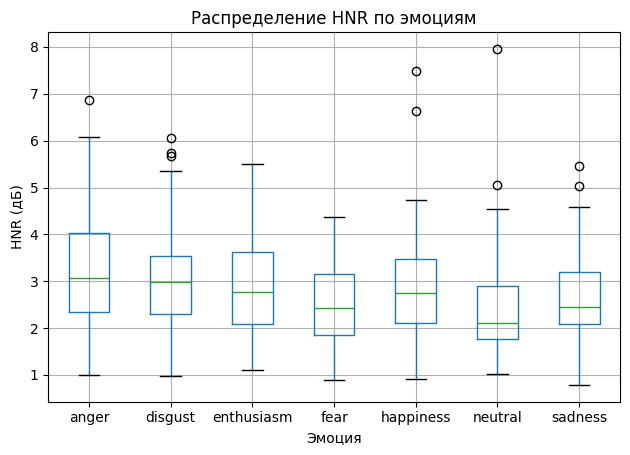

In [6]:
hnr_values = []
for _, row in df.iterrows():
    try:
        val = compute_hnr_from_bytes(add_noise_to_audio(row['speech']['bytes'],0.1))
    except Exception as e:
        print(f"Ошибка для {row['name']}: {e}")
        val = np.nan
    hnr_values.append(val)
df['HNR_dB'] = hnr_values

plt.figure(figsize=(10, 6))
df.boxplot(column='HNR_dB', by='emotion')
plt.title('Распределение HNR по эмоциям')
plt.suptitle('')
plt.ylabel('HNR (дБ)')
plt.xlabel('Эмоция')
plt.tight_layout()
plt.show()

C:\Users\Karl\AppData\Local\Temp\ipykernel_12844\1798854544.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, arr = wavfile.read(buf)


Результаты HNR сохранены в hnr_results.csv


<Figure size 1000x600 with 0 Axes>

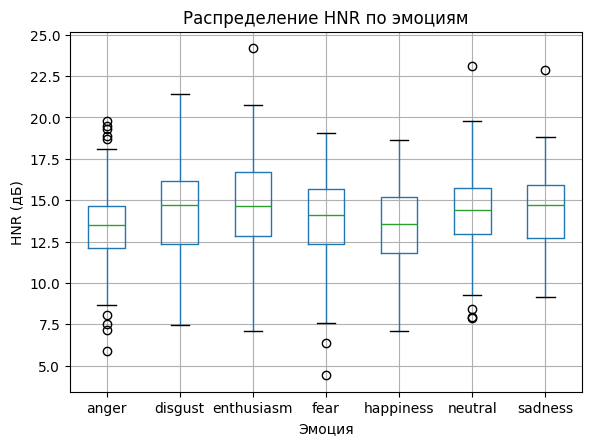

In [7]:
hnr_values = []
for _, row in df.iterrows():
    try:
        val = compute_hnr_from_bytes(row['speech']['bytes'])
    except Exception as e:
        print(f"Ошибка для {row['name']}: {e}")
        val = np.nan
    hnr_values.append(val)
df['HNR_dB'] = hnr_values

print("Результаты HNR сохранены в hnr_results.csv")

plt.figure(figsize=(10, 6))
df.boxplot(column='HNR_dB', by='emotion')
plt.title('Распределение HNR по эмоциям')
plt.suptitle('')
plt.ylabel('HNR (дБ)')
plt.xlabel('Эмоция')
plt.show()